## The project utilizes the **YOLOv8** structure to build a computer vision application which can detect and localise the desired object of interest in a frame, additionally tracking is made possible using the `model.track` function from ultralytics, Under the hood, the process begins with the YOLO model detecting objects in the current frame. Each detected object is assigned a *bounding box* and a *confidence score*. Then, the tracking algorithm associates these detected objects with previously tracked objects from earlier frames based on motion prediction and appearance features, maintaining consistent identities even if objects temporarily disappear or overlap.

### Acknowledgment, the code pipeline was inspired from: [https://github.com/insomnius/person-detection/tree/master](https://github.com/insomnius/person-detection/tree/master)

### Ultralytics Documentation: [https://docs.ultralytics.com/modes/train/](https://docs.ultralytics.com/modes/train/)

# 0. Dependencies and environment setup

In [ ]:
!pip install fiftyone    # we are using fifityone lib, to download and visualize the dataset. 

In [ ]:
# 
!pip install numpy==1.26.4 matplotlib==3.8.0 --force-reinstall --no-cache-dir

"""
there is a compatibility issue between the version of NumPy installed in this Kaggle environment 
and the compiled dependencies (like matplotlib, fiftyone, or their C/C++ extensions) that expect
NumPy 1.x, not 2.x.
"""

### **Please restart kernel**

In [ ]:
!pip install ultralytics  # yolo ultralytic dependencies

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(np.__version__)

1.26.4


# 1. Downloading dataset. [ensure stable internet]

## We will download coco-2017 dataset for *person* class only. let's download all the splits.

In [3]:
import fiftyone as fo
import fiftyone.zoo as foz
import matplotlib.pyplot as plt
import matplotlib.patches as patches

"""
Download coco-2017 dataset using fiftyone lib.
"""

# datasets = foz.load_zoo_dataset('coco-2017', splits=('train', 'validation', 'test'), classes=['person'], progress=True, max_samples=10000)

datasets = fo.Dataset.from_dir(
    dataset_dir='/kaggle/working/yolov5-coco-datasets',
    dataset_type=fo.types.COCODetectionDataset,
    labels_path="/kaggle/working/yolov5-coco-datasets/labels",
    data_path='/kaggle/working/yolov5-coco-datasets/images',
    name="coco-2017-local"
)

for sample in datasets:
  if sample.ground_truth == None:
    continue

  detections = [detection for detection in sample.ground_truth.detections if detection.label == "person"]
  sample.ground_truth.detections = detections
  sample.save()

# Export the splits
for split in ['train', 'validation', 'test']:
    split_view = datasets.match_tags(split)
    split_view.export(
        export_dir='./yolov5-coco-datasets',
        dataset_type=fo.types.YOLOv5Dataset,
        label_field='ground_truth',
        split=split,
        classes=['person'],
    )

You are running the oldest supported major version of MongoDB. Please refer to https://deprecation.voxel51.com for deprecation notices. You can suppress this exception by setting your `database_validation` config parameter to `False`. See https://docs.voxel51.com/user_guide/config.html#configuring-a-mongodb-connection for more information
 100% |█████████████████████| 0/0 [2.2ms elapsed, ? remaining, ? samples/s]  
Directory './yolov5-coco-datasets' already exists; export will be merged with existing files
 100% |█████████████████████| 0/0 [1.1ms elapsed, ? remaining, ? samples/s] 
Directory './yolov5-coco-datasets' already exists; export will be merged with existing files
 100% |█████████████████████| 0/0 [1.1ms elapsed, ? remaining, ? samples/s] 
Directory './yolov5-coco-datasets' already exists; export will be merged with existing files
 100% |█████████████████████| 0/0 [1.1ms elapsed, ? remaining, ? samples/s] 


In [4]:
datasets

Name:        coco-2017-local
Media type:  None
Num samples: 0
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField

In [ ]:
"""
Let's visualise the dataset.
"""


def show_sample(split_view):
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle("Sample Image From Coco 2017 Dataset, Classes: [person]")
    i = 1
    for d in split_view.take(5):
        ax = fig.add_subplot(1, 5, i)
        ax.set_title(f"Tags: {d.tags}\n")
        img = plt.imread(d.filepath)
        ax.imshow(img)
        ax.axis('off')
        i += 1

        # Skip for testing data
        if d.ground_truth is None:
            continue

        for detection in d.ground_truth.detections:
            x, y, w, h = detection.bounding_box
            image_height, image_width, _ = img.shape
            x1 = x * image_width
            y1 = y * image_height
            x2 = x1 + (w * image_width)
            y2 = y1 + (h * image_height)
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

for split in ['train', 'validation', 'test']:
    split_view = datasets.match_tags(split)
    show_sample(split_view)

# 2. Create model instance. 

In [8]:
from ultralytics import YOLO
from PIL import Image
import cv2
import matplotlib.pyplot as plt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
'''
Loading yolo 8 nano model. 
'''

model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [13]:
results = model.train(data='./yolov5-coco-datasets/dataset.yaml', epochs=70, imgsz=640, device=[-1,-1], batch=32, plots=True, seed=18, project='./training/yolov8n')


Searching for 1 idle GPUs with free memory >= 20.0% and free utilization >= 0.0%...
Selected idle CUDA devices [0]
Ultralytics 8.3.223 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./yolov5-coco-datasets/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/training/yolov8n/train/weights/last.pt, momentum=0.937, mosaic=1.0,

AssertionError: /kaggle/working/training/yolov8n/train/weights/last.pt training to 50 epochs is finished, nothing to resume.
Start a new training without resuming, i.e. 'yolo train model=/kaggle/working/training/yolov8n/train/weights/last.pt'

# 2. make predictions


0: 640x640 2 persons, 89.2ms
1: 640x640 2 persons, 89.2ms
2: 640x640 5 persons, 89.2ms
3: 640x640 11 persons, 89.2ms
Speed: 3.4ms preprocess, 89.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


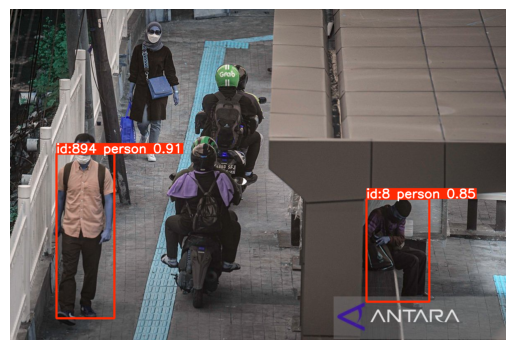

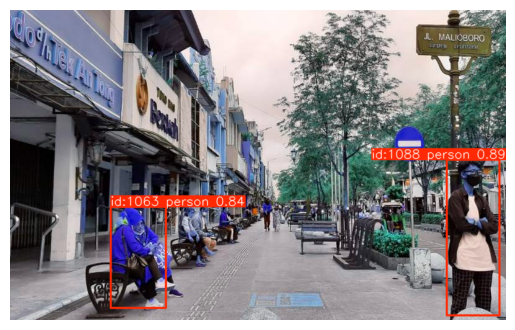

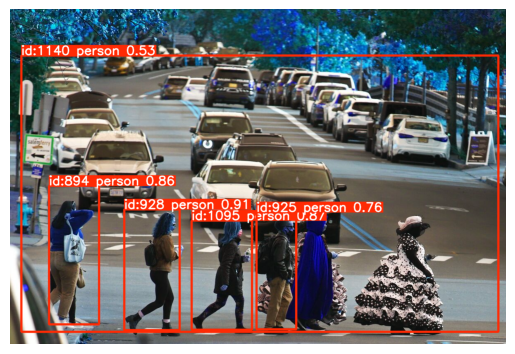

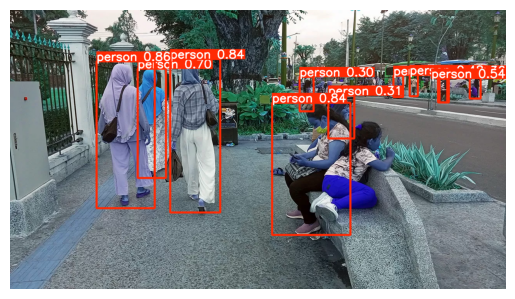

In [74]:
import os

predictions = model.predict(source=['https://cdn.antaranews.com/cache/1200x800/2023/10/13/Pengendara-Sepeda-Motor-Trotoar-060323-aaa-5.jpg','https://img.harianjogja.com/posts/2022/11/14/1117643/jalur-pedestrian-malioboro.jpg', 'https://assets.bwbx.io/images/users/iqjWHBFdfxIU/i.KTm08H6tuM/v1/1200x810.jpg', 'https://static.promediateknologi.id/crop/0x0:0x0/0x0/webp/photo/radarjogja/2023/01/web-JOG-Pedestrian-Harus-Sesuai-Fungsinya-FAT-010122.jpg'])
# predictions=model.predict(source="https://youtu.be/gAuJlwnUqMs?si=zKgWHNfecvFMQokr")

for p in predictions:
  %matplotlib inline
  plt.axis('off')
  plt.imshow(p.plot())
  plt.show()

## **Confusion Matrix**

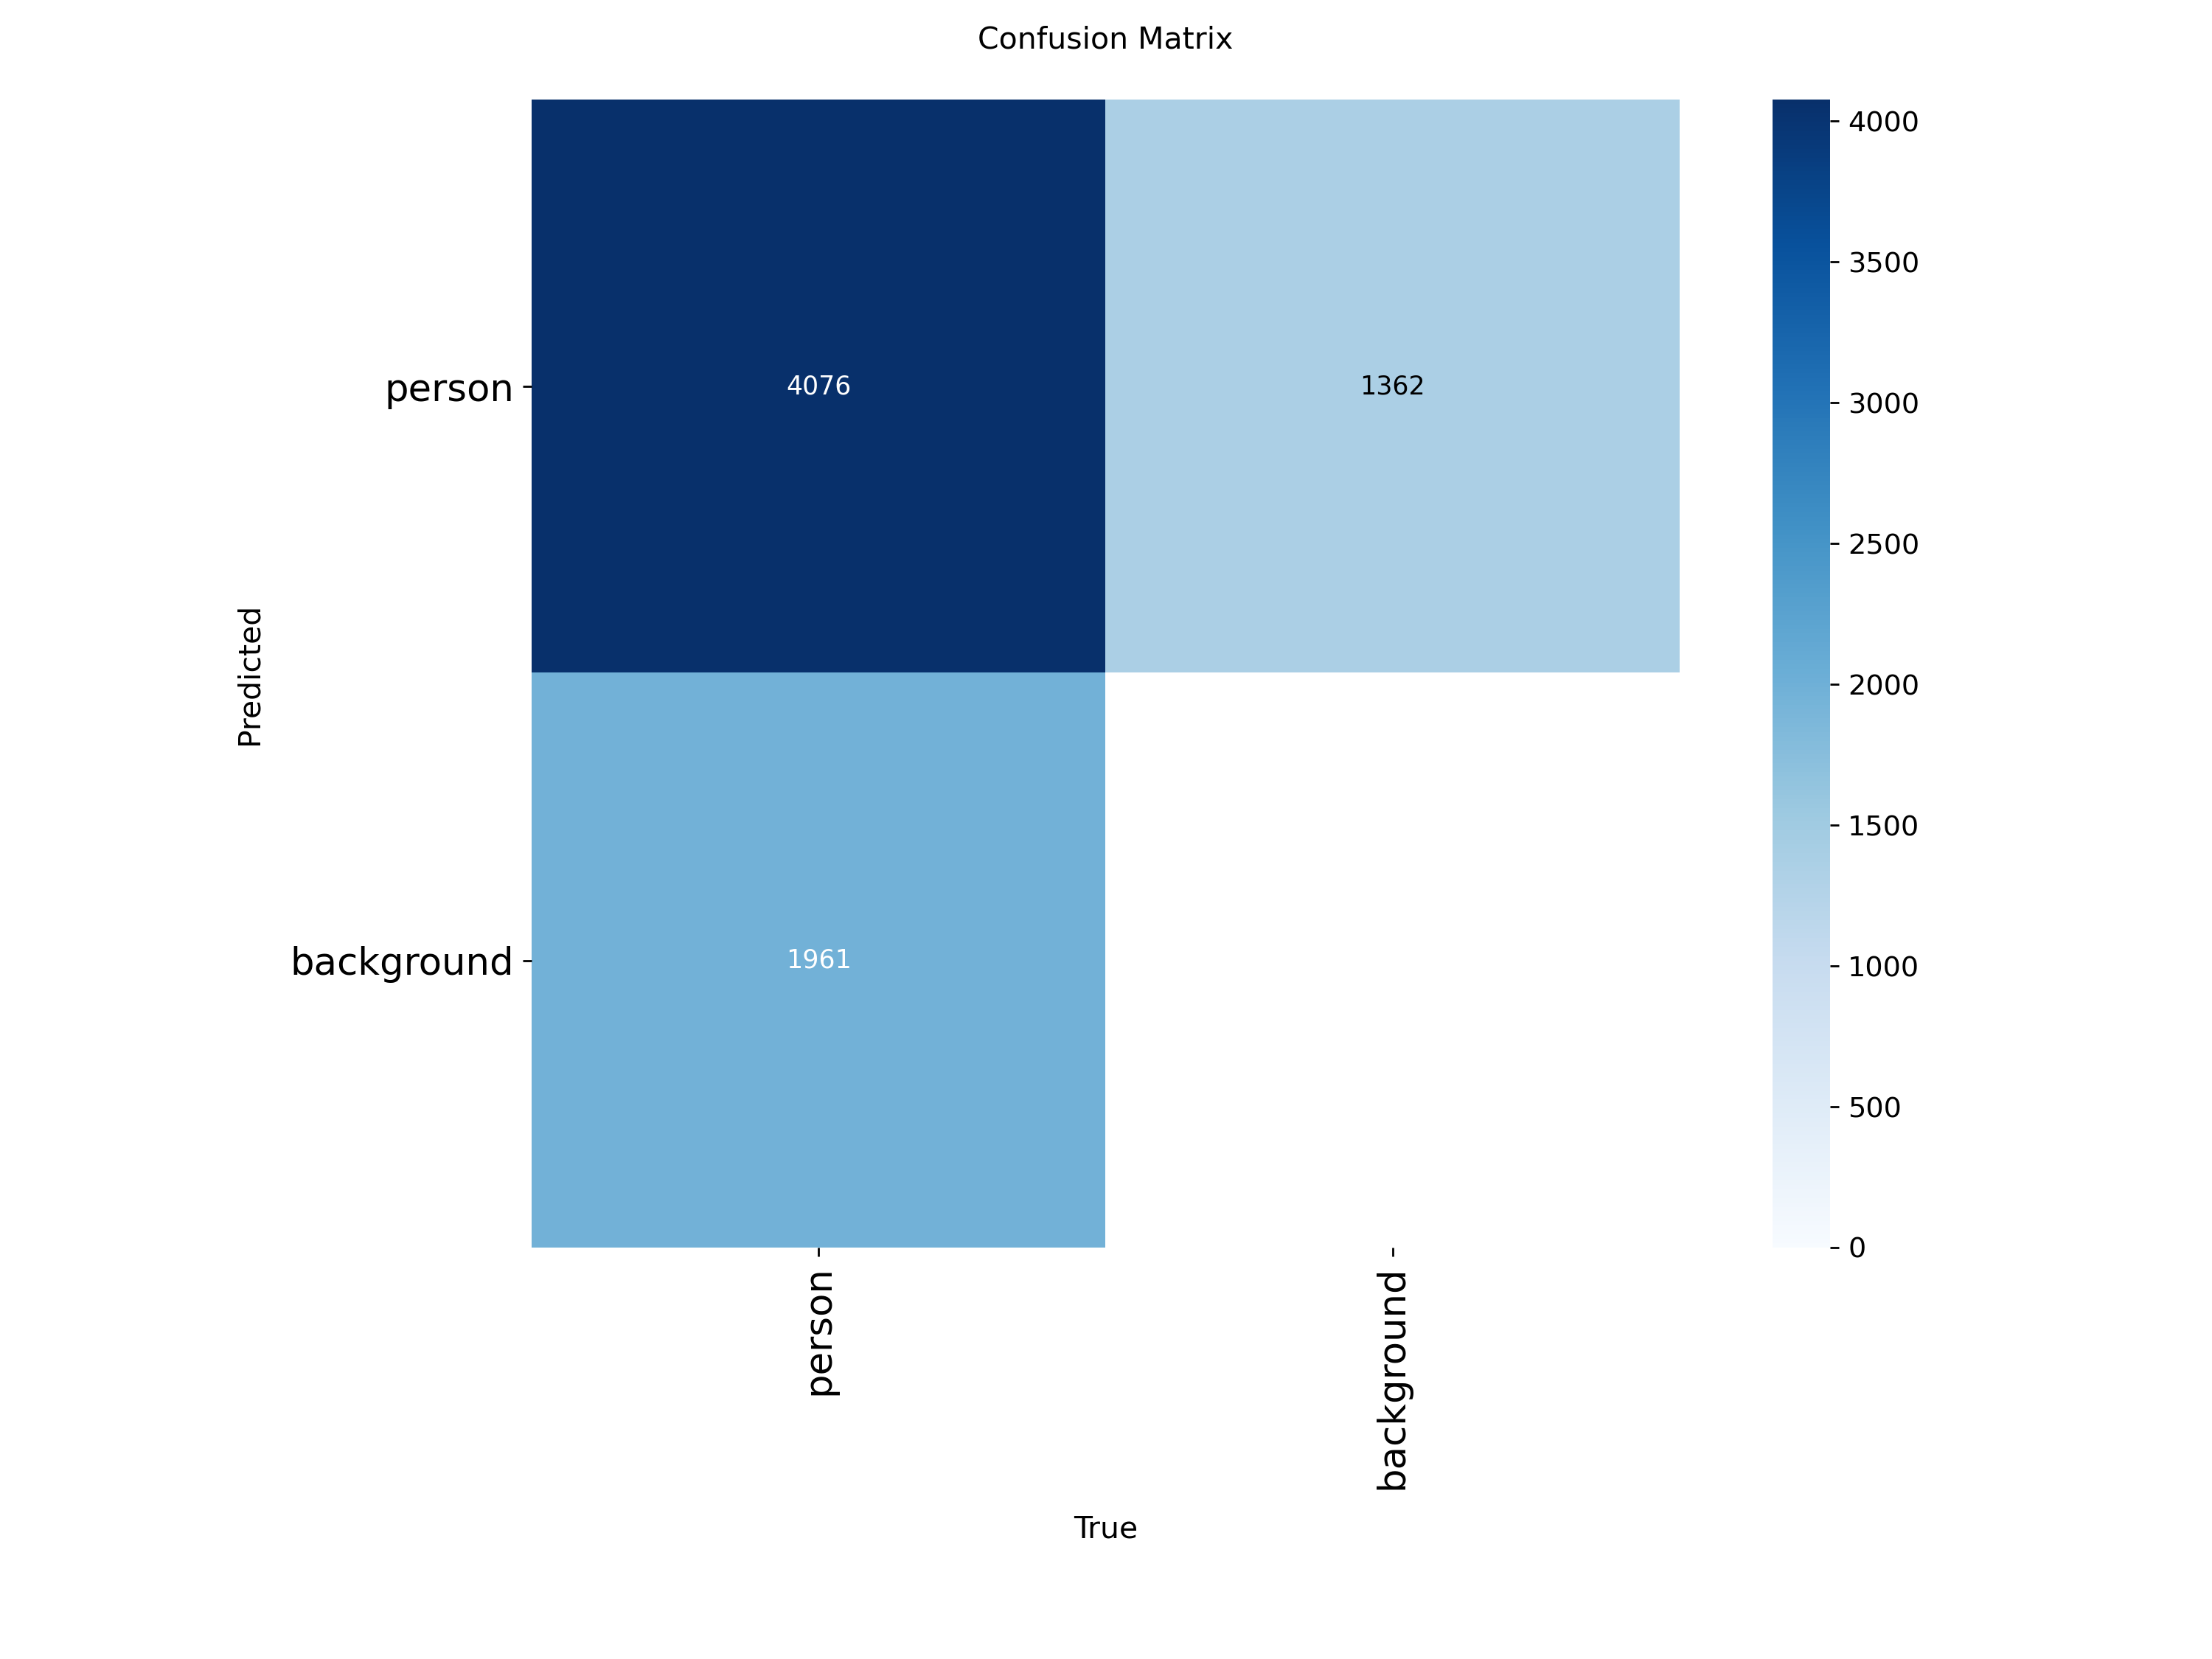

In [75]:
from IPython.display import Image, display

image_path = "/kaggle/working/training/yolov8n/train/confusion_matrix.png"
display(Image(filename=image_path))


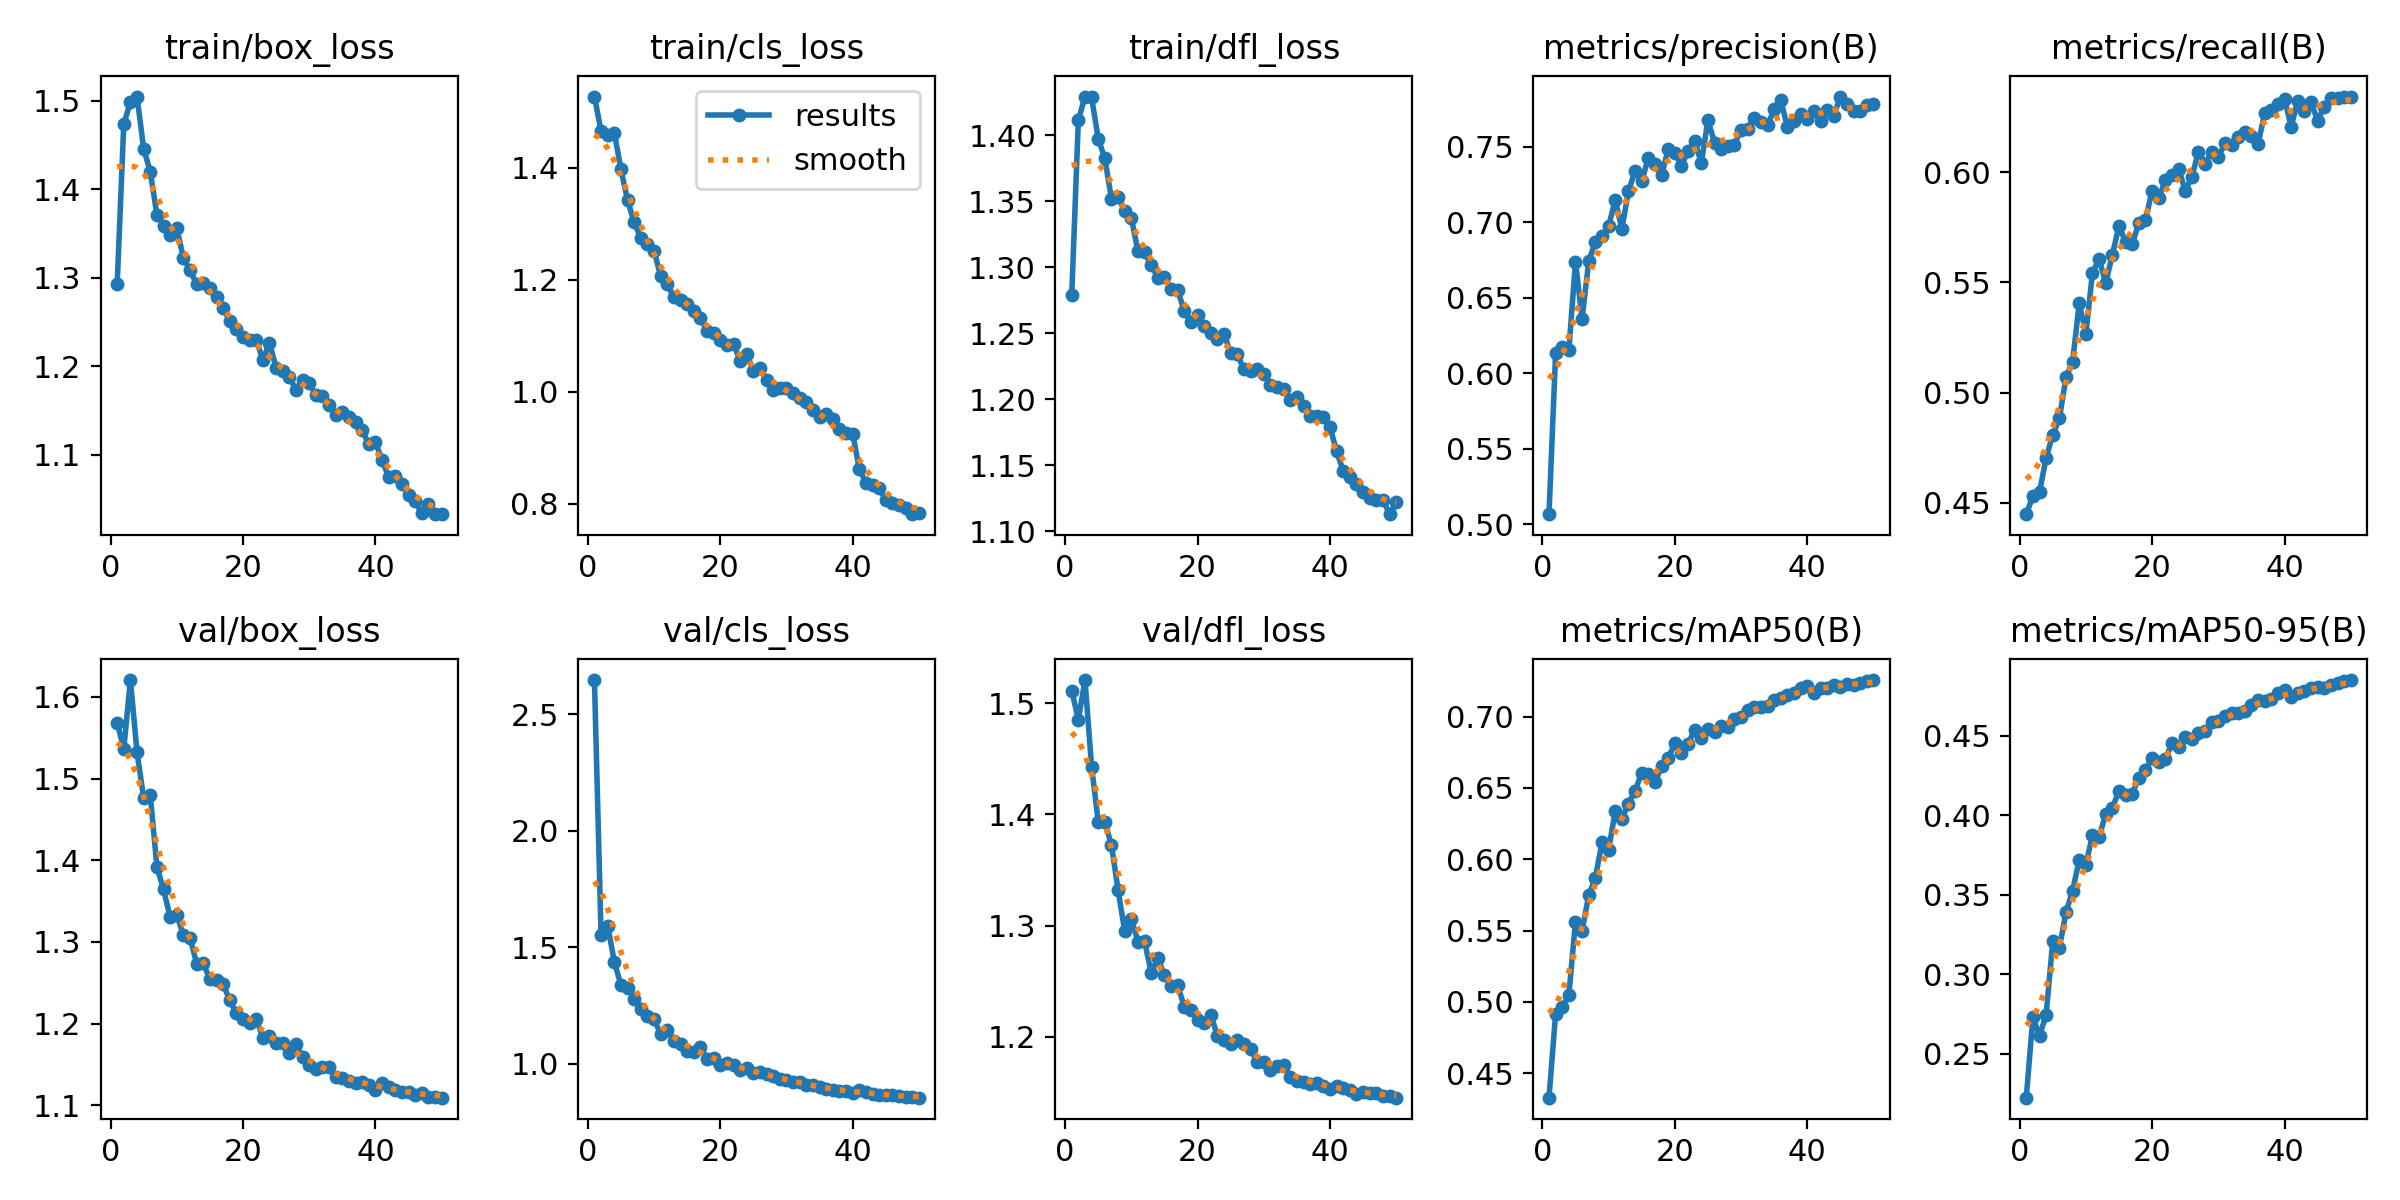

In [76]:
from IPython.display import Image, display

image_path = "/kaggle/working/training/yolov8n/train/results.png"
display(Image(filename=image_path))


# 3. Download a sample video and then perform tracking.

In [16]:
!pip install yt-dlp
!yt-dlp https://youtu.be/gAuJlwnUqMs?si=zKgWHNfecvFMQokr

!pip install moviepy

from moviepy.editor import VideoFileClip


''' 
Let's download a sample video from yt.
'''

# Load the .webm file
clip = VideoFileClip("/kaggle/working/People Entering And Exiting Mall Stock Footage [gAuJlwnUqMs].mkv")

# Write it out as .mp4
clip.write_videofile("/kaggle/working/output.mp4", codec="libx264")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 kB 4.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 52.4 MB/s eta 0:00:00a 0:00:01
[youtube] Extracting URL: https://youtu.be/gAuJlwnUqMs?si=zKgWHNfecvFMQokr
[youtube] gAuJlwnUqMs: Downloading webpage
[youtube] gAuJlwnUqMs: Downloading android sdkless player API JSON
[youtube] gAuJlwnUqMs: Downloading tv client config
[youtube] gAuJlwnUqMs: Downloading player c6d7bdc9-main
[youtube] gAuJlwnUqMs: Downloading tv player API JSON
[youtube] gAuJlwnUqMs: Downloading web safari player API JSON
         player = https://www.youtube.com/s/player/c6d7bdc9/player_ias.vflset/en_US/base.js
         n = 0fBCD8ZYJkcamTjm ; player = https://www.youtube.com/s/player/c6d7bdc9/player_ias.vflset/en_US/base.js
         Please report this issue on  https://github.com/yt-dlp/yt-dlp/issues?q= , filling out the appropriate issue template. Confirm you are on the latest version using  yt-dlp -U
[youtube] gAuJlwnUqMs: Downloa

Speed: 2.4ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /kaggle/working/runs/detect/track
Tracking video complete...
There are 101 peoples in video


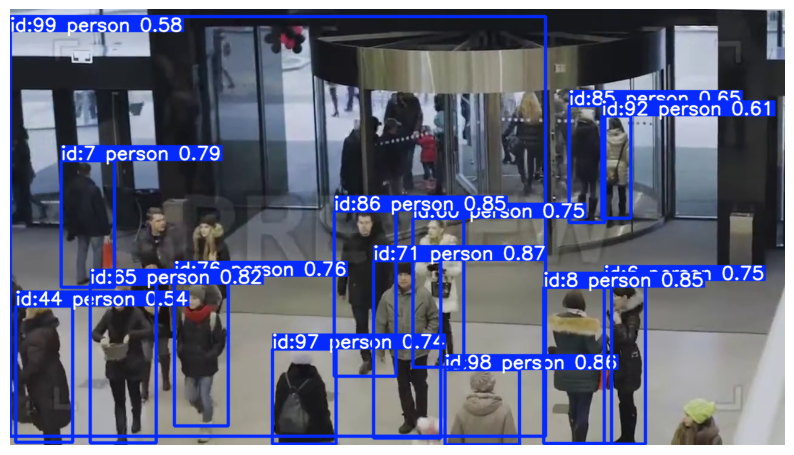

In [23]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import cv2

model_path = '/kaggle/working/training/yolov8n/train/weights/best.pt'
video_path = '/kaggle/working/People Entering And Exiting Mall Stock Footage [gAuJlwnUqMs].mkv'
model = YOLO(model_path)

results = model.track(video_path, persist=True, stream=True, conf=0.5, save=True)
 

# 4. Check out the result from the yt link.

[https://www.youtube.com/embed/R-vlPXQGyVQ](url)


<iframe width="640" height="640"
src="https://www.youtube.com/embed/R-vlPXQGyVQ"
frameborder="0" allowfullscreen></iframe>
